# Energy Estimator (updated)

---

Aditya Marathe

## Imports

In [216]:
import os
import sys

import pathlib

In [217]:
%matplotlib inline

import dotenv

import h5py
# import dask
# import dask.dataframe as dd
# import dask.array as da
import pandas as pd

import json

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras
# import keras.backend as kb

from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local Imports**

In [218]:
sys.path.insert(1, './../')

from cuts import *
from utils import *

**Version and Hardware**

In [4]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
# print(f'Dask {dask.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
Matplotlib 3.8.1


In [5]:
# The '.env' file contains the directory to the data.
dotenv.load_dotenv();

## Setting up logging...

In [6]:
config = {
    'Cuts': list(),
    'Transforms': list(),
    'XData': list(),
    'YData': list(),
    'HyperParameters': dict()
}

## 1. Loading the 'mini' dataset

In [7]:
DATA_FILE_DIR = pathlib.Path(os.environ['MINI_DATA_DIR'])

In [8]:
useful_vars = [
    # Cuts (not used for training / testing)
    'numuBasicQuality',
    'numuQuality',
    'numucontain',
    'numu2020pid',
    'numucosrej',
    '3flavourveto',
    'numufull',
    # MC Truth
    'isNuMuCC',
    'trueEnu',
    # Derived Quant.
    'pmu',
    'pt',
    'ptp',
    'recoq2',
    'cosBeamFirst',
    # Predicted energies
    'rec.energy.numu.hadclust.calE',
    'rec.energy.numu.hadclust.nhit',
    'rec.energy.numu.hadtrkE',
    'rec.energy.numu.lstmmuon',
    'rec.energy.numu.lstmnu',
    # Pre-selection CVN
    'rec.sel.cvnloosepreselptp.cosmicid',
    'rec.sel.cvnloosepreselptp.ncid',
    'rec.sel.cvnloosepreselptp.nueid',
    'rec.sel.cvnloosepreselptp.numuid',
    # Selection and PIDs
    'rec.sel.contain.cosbakcell',
    'rec.sel.remid.pid',
    'rec.sel.scann.scpid',
    # Time Slice
    'rec.slc.ncontplanes',
    'rec.slc.nhit',
    # Reconstructed Tracks
    'rec.trk.kalman.ntracks'
]

In [9]:
def load_dataset(n_events: int = 2_000_000) -> pd.DataFrame:
    """
    Loads the first n events from the total data.

    Args
    ----
    n_events: int
        The number of events to load.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` object containing the loaded data.
    """
    with h5py.File(DATA_FILE_DIR, 'r') as file:
        df = pd.DataFrame(
            data={key: file[key][:n_events] for key in file.keys()}
        )

    # Filter out the unwanted columns + rearrange the columns
    return df[useful_vars]


## 2. Data pre-processing

In [10]:
def quality_cut_transform(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Applies basic quality cuts to a Pandas `DataFrame`.

    Args
    ----
    df: pd.DataFrame
        The target Pandas `DataFrame` object.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` with the applied transfromation.
    """
    df_copy = df.copy()

    # Detector + data quality cuts
    df_copy = df_copy[df_copy['numuQuality'] & df_copy['numuBasicQuality']]

    config['Cuts'].extend(['numuQuality', 'numuBasicQuality'])

    # Possibly redundant code to ensure positive energies
    targets = [
        'rec.energy.numu.hadclust.calE',
        'rec.energy.numu.hadtrkE',
        'rec.energy.numu.lstmmuon',
        'rec.energy.numu.lstmnu',
    ]

    for target in targets:
        df_copy = df_copy[df_copy[target] >= 0.]

    return df_copy

In [11]:
def pid_cut_transform(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Applies PID cut to a Pandas `DataFrame`.

    Args
    ----
    df: pd.DataFrame
        The target Pandas `DataFrame` object.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` with the applied transfromation.
    """
    df_copy = df[df['numu2020pid']].copy()

    config['Cuts'].append('numu2020pid')

    return df_copy

In [12]:
def vaild_pid_transform(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Ensures valid PID scores which fall between 0 and 1.

    Args
    ----
    df: pd.DataFrame
        The target Pandas `DataFrame` object.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` with the applied transfromation.
    """
    df_copy = df.copy()

    # The PID Scores must be between 0 and 1
    target_cols = [
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.nueid',
        'rec.sel.cvnloosepreselptp.numuid',
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid'
    ]

    for col in target_cols:
        df_copy[(df_copy[col] < 0) & (df_copy[col] > 1)] = 0.

    return df_copy

In [13]:
def background_cut_transform(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Cuts out all background data using MC truth information.

    (I.e. we are only left with signal events...)

    Args
    ----
    df: pd.DataFrame
        The target Pandas `DataFrame` object.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` with the applied transfromation.
    """
    df_copy = df[df['isNuMuCC']].copy()

    config['Cuts'].append('isNuMuCC')

    return df_copy

In [14]:
def high_energy_cut_transform(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Cuts out all data with energies above 5 GeV.

    (I.e. we are only left with signal events...)

    Args
    ----
    df: pd.DataFrame
        The target Pandas `DataFrame` object.

    Returns
    -------
    pd.DataFrame
        Pandas `DataFrame` with the applied transfromation.
    """
    df_copy = df.copy()

    targets = [
        'trueEnu',
        'rec.energy.numu.lstmmuon',
        'rec.energy.numu.lstmnu'
    ]

    for target in targets:
        df_copy = df_copy[df_copy[target] <= 5.]

    return df_copy

## 3. Run 1

### 3.1 Data analysis and prep.

In [215]:
df = load_dataset(n_events=10_000_000)

In [203]:
# Apply transforms...
transforms = [
    quality_cut_transform,
    vaild_pid_transform,
    pid_cut_transform,
    background_cut_transform,
    high_energy_cut_transform
]

for transform in transforms:
    df = transform(df)
    config['Transforms'].append(transform.__name__)

# TODO: TEMP
df = df[df['numucontain'] == False]

# Rest the indices...
df.reset_index(inplace=True, drop=True)

In [204]:
# Remove the unecessary params.
for column_name in useful_vars[:8]:
    try:
        df.drop(columns=column_name, inplace=True)
    except KeyError:
        pass

In [205]:
# Seperate the LSTM Enu column for later comparison...
# (Of course this cannot be used for training either!)
df_lstmnu = df.pop('rec.energy.numu.lstmnu')

In [206]:
# Dict of the param. names and their correlations, ordered by how strong their
# correlation is with the true Enu value...
var_corr_dict = dict(
    sorted(
        dict(df.corr()['trueEnu'][1:]).items(), 
        key=lambda x: np.abs(x[1]), 
        reverse=True
    )
)

# var_corr_dict

In [207]:
# Get top n params. which are the most correlated to true Enu
N_PARAMS: int = 7
strongly_corr_params = list(var_corr_dict.keys())[:N_PARAMS]

### 3.2 Training/testing data

In [208]:
df_temp = df.copy()

df_y = df_temp.pop('trueEnu')
df_x = df_temp.copy()

config['XData'].extend(df_x.columns)
config['YData'].append(df_y.name)

del df_temp

In [209]:
def tt_split(
        df_x: pd.DataFrame,
        df_y: pd.Series,
        train_size: float = 0.8,
        shuffle: bool = False,
        random_state: int = 42
    ) -> dict[str, pd.DataFrame | pd.Series]:
    """\
    """
    if shuffle:
        ...
    
    train_index = int(len(df) * 0.8)

    return {
        'TrainX': df_x[:train_index], 
        'TrainY': df_y[:train_index], 
        'TestX': df_x[train_index:], 
        'TestY': df_y[train_index:]
    }

In [210]:
tt_data = tt_split(df_x, df_y)

In [211]:
std_scaler = preprocessing.StandardScaler()
tt_data['ScaledTrainX'] = std_scaler.fit_transform(tt_data['TrainX'])
tt_data['ScaledTestX'] = std_scaler.transform(tt_data['TestX'])

[0.  1.8 2.  2.2 2.2]


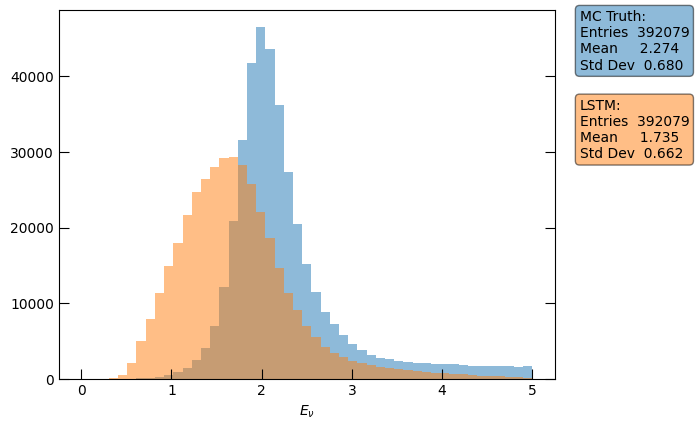

In [212]:
fig, ax = custom_subplots()

_a = np.linspace(0, 1.8, 1)
_b = np.linspace(1.8, 2.2, 3)
_c = np.linspace(2.2, 5, 1)

_d = np.concatenate([_a, _b, _c])

print(_d)

# np.linspace(0, 5, 50)

# labelled_hist(ax=ax, data=df_y, bins=_d, alpha=0.5, label='MC Truth')
labelled_hist(ax=ax, data=df_y, bins=np.linspace(0, 5, 50), alpha=0.5, label='MC Truth')
labelled_hist(ax=ax, data=df_lstmnu, bins=np.linspace(0, 5, 50), alpha=0.5, label='LSTM')

ax.set_xlabel(r'$E_\nu$');

In [213]:
alpha = 0.

weight_1 = 100.
weight_2 = 100.

lower_threshold = 1.5  # GeV
upper_threshold = 2.5  # GeV


def mse_and_msle(y_true, y_pred):
    # y_true = tf.cast(y_true, tf.float32)
    # y_pred = tf.cast(y_pred, tf.float32)

    loss = (
        keras.losses.mean_squared_error(y_true, y_pred)
        + alpha * keras.losses.mean_squared_logarithmic_error(y_true, y_pred)
    )

    # loss = tf.where(y_true <= lower_threshold, loss * weight_1, loss)
    # loss = tf.where(y_true >= upper_threshold, loss * weight_2, loss)

    return loss

In [214]:
model_config = {
    'SequentialLayers': [
        keras.layers.InputLayer(input_shape=(19,)),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(units=1, activation=keras.activations.linear)
    ],
    'Optimizer': keras.optimizers.Adam(learning_rate=1E-3),
    'LossFunction': keras.losses.mean_squared_error
}

In [186]:
def init_model() -> keras.Sequential:
    """\
    """
    model = keras.Sequential(layers=model_config['SequentialLayers'])

    model.compile(
        optimizer=model_config['Optimizer'],
        loss=model_config['LossFunction'],
        metrics=[
            keras.metrics.MeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ],
        weighted_metrics=[]
    )

    return model

In [195]:
EPOCHS = 100

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True
)

sample_weight = np.ones(shape=tt_data['TrainY'].shape)
sample_weight[tt_data['TrainY'] <= 1.2] = 5.
sample_weight[tt_data['TrainY'] >= 2.2] = 5.

# values = np.histogram(df_y, bins=np.linspace(0, 5, 50))[0] + 1E-3
# weights = values.max() / values

# sample_weight = np.digitize(df_y, bins=np.linspace(0, 5, 50))

# for i in range(sample_weight.max()):
#     sample_weight[sample_weight == i] = weights[i]

In [196]:
model = init_model()
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8)                 160       
                                                                 
 dense_19 (Dense)            (None, 16)                144       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [197]:
model_history = model.fit(
    x=tt_data['ScaledTrainX'], 
    y=tt_data['TrainY'] / 5,
    validation_split=0.2,
    epochs=EPOCHS,
    # shuffle=True,
    sample_weight=sample_weight,
    callbacks=[
        early_stopping
    ]
)

Epoch 1/100
1816/1816 [==============================] - 6s 3ms/step - loss: 0.0337 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0837 - val_loss: 0.0345 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0810
Epoch 2/100
1816/1816 [==============================] - 2s 1ms/step - loss: 0.0339 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0837 - val_loss: 0.0354 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0795
Epoch 3/100
1816/1816 [==============================] - 2s 1ms/step - loss: 0.0338 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0835 - val_loss: 0.0369 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0795
Epoch 4/100
1816/1816 [==============================] - 3s 2ms/step - loss: 0.0338 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0834 - val_loss: 0.0356 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0816
Epoch 5/100
1816/1816 [==============================] - 3s 2ms/step - loss: 0.0335 

#### TESTING...

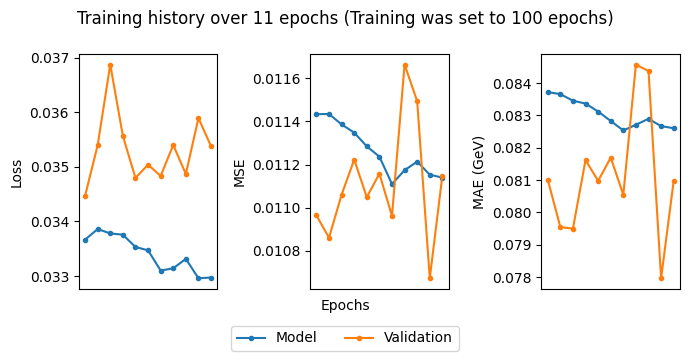

In [198]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3))

axs = axs.flatten()

actual_epochs = range(1, len(model_history.history['loss']) + 1)

axs[0].plot(actual_epochs, model_history.history['loss'], '.-')
axs[0].plot(actual_epochs, model_history.history['val_loss'], '.-')
axs[0].set_ylabel('Loss')

axs[1].plot(actual_epochs, model_history.history['mean_squared_error'], '.-')
axs[1].plot(actual_epochs, model_history.history['val_mean_squared_error'], '.-')
axs[1].set_ylabel('MSE')

axs[2].plot(actual_epochs, model_history.history['mean_absolute_error'], '.-')
axs[2].plot(actual_epochs, model_history.history['val_mean_absolute_error'], '.-')
axs[2].set_ylabel('MAE (GeV)')

for ax in axs:
    ax.set_xticks([])

fig.text(0.5, -0.02, 'Epochs', ha='center')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['Model', 'Validation'])

fig.suptitle(f'Training history over {len(actual_epochs)} epochs (Training was set to {EPOCHS} epochs)')

plt.tight_layout()

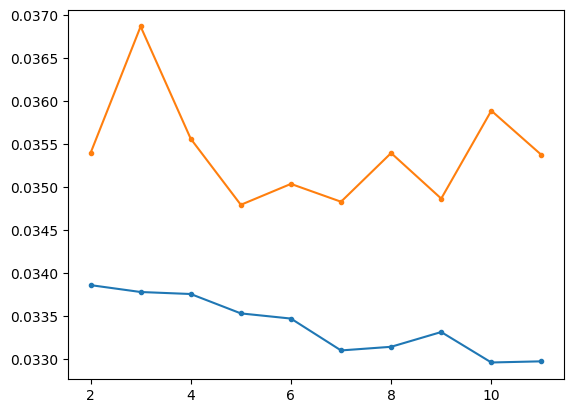

In [199]:
plt.plot(actual_epochs[1:], model_history.history['loss'][1:], '.-')
plt.plot(actual_epochs[1:], model_history.history['val_loss'][1:], '.-')


In [200]:
model_pred = model.predict(tt_data['ScaledTestX'])

568/568 [==============================] - 0s 739us/step


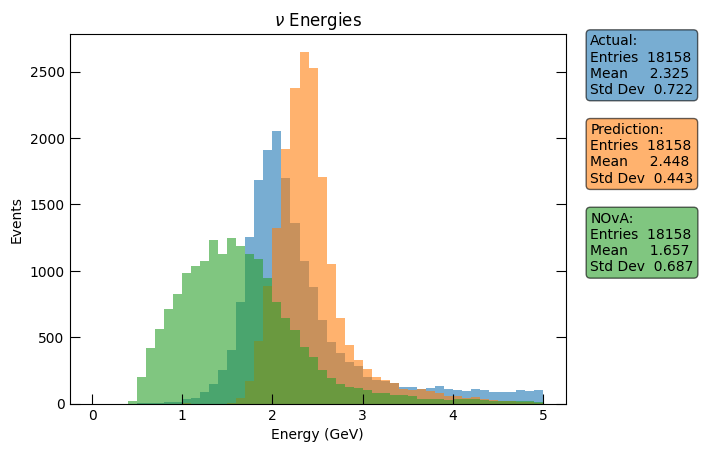

In [201]:
fig, ax = custom_subplots()

bins_conf = np.linspace(0, 5, 50 + 1)

labelled_hist(ax, tt_data['TestY'], bins=bins_conf, alpha=0.6, label='Actual')
labelled_hist(ax, model_pred * 5, bins=bins_conf, alpha=0.6, label='Prediction')
labelled_hist(ax, df_lstmnu[int(df_y.shape[0] * 0.8):], bins=bins_conf, alpha=0.6, label='NOvA')

ax.set_title(r'$\nu$ Energies')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');

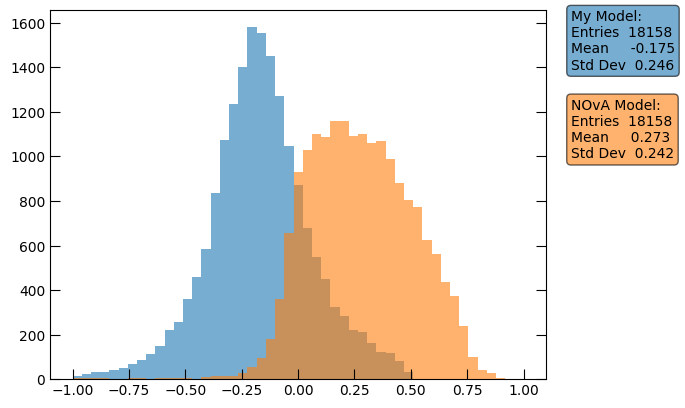

In [194]:
frac_residuals_1 = 1 - (model_pred * 5).flatten()/tt_data['TestY']
frac_residuals_2 = 1 - df_lstmnu[int(df_y.shape[0] * 0.8):]/tt_data['TestY']

fig, ax = custom_subplots()

labelled_hist(ax, frac_residuals_1, bins=np.linspace(-1, 1, 50), alpha=0.6, label='My Model')
labelled_hist(ax, frac_residuals_2, bins=np.linspace(-1, 1, 50), alpha=0.6, label='NOvA Model');

In [61]:
np.sqrt(np.mean(frac_residuals_1**2)) * 100

15.9054696559906

In [62]:
np.sqrt(np.mean(frac_residuals_2**2)) * 100

23.66996854543686

In [46]:
df_2 = load_dataset(n_events=5_000_000)

In [47]:
df_2 = df_2[
    df_2['numuBasicQuality']
    & df_2['numuQuality']
    & df_2['numu2020pid']
    & df_2['numucosrej']
    & df_2['3flavourveto']
].drop(columns=df_2.columns[:8])

In [48]:
df_2_trueEnu = df_2.pop('trueEnu')
df_2_lstmnu = df_2.pop('rec.energy.numu.lstmnu')

In [49]:
df_2_pred = model.predict(
    std_scaler.transform(df_2[(df_2_trueEnu < 5) & (df_2_trueEnu > 0)])
)

21919/21919 [==============================] - 25s 1ms/step


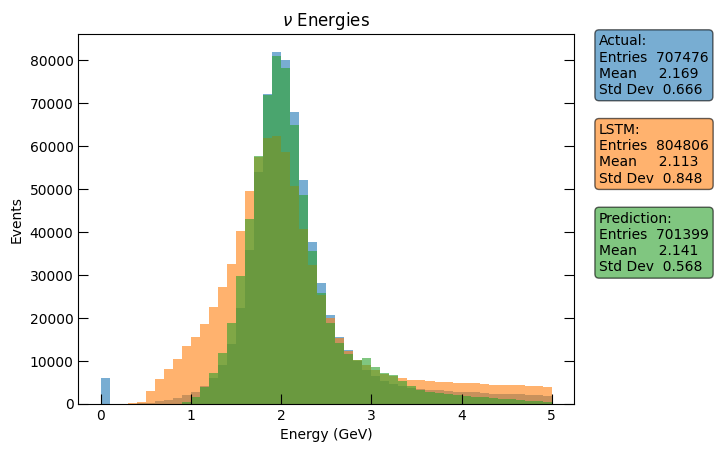

In [50]:
fig, ax = custom_subplots()

bins_conf = np.linspace(0, 5, 50 + 1)

labelled_hist(ax, df_2_trueEnu[df_2_trueEnu < 5], bins=bins_conf, alpha=0.6, label='Actual')
labelled_hist(ax, df_2_lstmnu, bins=bins_conf, alpha=0.6, label='LSTM')
labelled_hist(ax, df_2_pred / 100, bins=bins_conf, alpha=0.6, label='Prediction')

ax.set_title(r'$\nu$ Energies')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');